# Importing libraries

In [137]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.optim as optim

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# width of the print
np.set_printoptions(linewidth=300)

# Data generation

In [135]:
# Logistic function
def logistic_curve(x, L, k, x0, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

def add_noise(data, noise_level=0.05):
    noise = np.random.normal(0, noise_level, len(data))
    noise_cumulative = np.cumsum(np.random.normal(0, 2.5, len(data)))
    return data + noise + noise_cumulative

# Generate data
t = np.linspace(0, 2500, 2500)  # x-axis points
curve_1 = add_noise(logistic_curve(t, 1000, 0.005, 1250, 0.05), noise_level=1)
curve_2 = add_noise(logistic_curve(t, 1200, 0.0035, 1525, 0.1), noise_level=1)
curve_3 = add_noise(logistic_curve(t, 1390, 0.006, 1750, 0.1), noise_level=1)
curve_5 = add_noise(logistic_curve(t, 950, 0.0025, 1654, 0.003), noise_level=1)
curve_6 = add_noise(logistic_curve(t, 1300, 0.004, 1354, 0.002), noise_level=1)
curve_4 = add_noise(logistic_curve(t, 1150, 0.0025, 1554, 0.001), noise_level=1)
curve_10 = add_noise(logistic_curve(t, 1150, 0.0015, 1554, 0.001), noise_level=1)
curve_11 = add_noise(logistic_curve(t, 730, 0.01, 1650, 0.01), noise_level=1)


combined_data = np.concatenate((curve_1, curve_2, curve_3, curve_5, curve_6, curve_10), axis=0)

# Normalize training data
scaler_train = MinMaxScaler()
combined_train_data_scaled = scaler_train.fit_transform(combined_data.reshape(-1, 1)).flatten()

# Normalize val data
scaler_val = MinMaxScaler()
curve_4_scaled = scaler_val.fit_transform(curve_4.reshape(-1, 1)).flatten()
curve_11_scaled = scaler_val.fit_transform(curve_11.reshape(-1, 1)).flatten()


curve_1_scaled = combined_train_data_scaled[:len(curve_1)]
curve_2_scaled = combined_train_data_scaled[len(curve_1):len(curve_1) + len(curve_2)]
curve_3_scaled = combined_train_data_scaled[len(curve_1) + len(curve_2):len(curve_1) + len(curve_2) + len(curve_3)]
curve_5_scaled = combined_train_data_scaled[len(curve_1) + len(curve_2) + len(curve_3):len(curve_1) + len(curve_2) + len(curve_3) + len(curve_5)]
curve_6_scaled = combined_train_data_scaled[len(curve_1) + len(curve_2) + len(curve_3) + len(curve_5):len(curve_1) + len(curve_2) + len(curve_3) + len(curve_5) + len(curve_6)]
curve_10_scaled = combined_train_data_scaled[len(curve_1) + len(curve_2) + len(curve_3) + len(curve_5) + len(curve_6):]


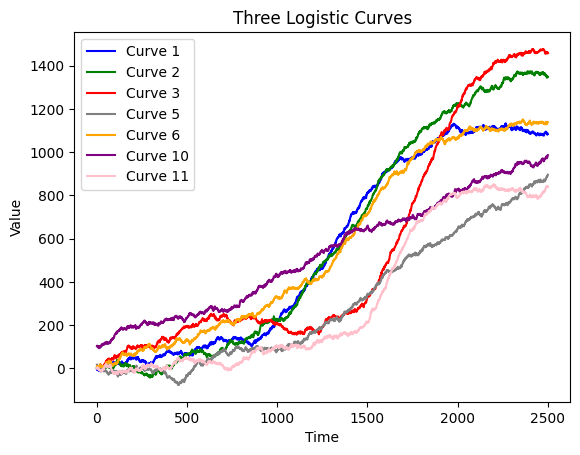

In [136]:
plt.plot(t, curve_1, label="Curve 1", color="blue")
plt.plot(t, curve_2, label="Curve 2", color="green")
plt.plot(t, curve_3, label="Curve 3", color="red")
plt.plot(t, curve_5, label="Curve 5", color="grey")
plt.plot(t, curve_6, label="Curve 6", color="orange")
plt.plot(t, curve_10, label="Curve 10", color="purple")
plt.plot(t, curve_11, label="Curve 11", color="pink")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Three Logistic Curves")
plt.legend()
plt.show()


# Data preparation pytorch *Dataset* and *DataLoader*

In [81]:

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        """
        Parameters:
        - data: 1D array or list of time series data.
        - seq_len: Length of input sequences.
        """

        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        # Handle edge case where data is too short
        return max(0, len(self.data) - self.seq_len)

    def __getitem__(self, idx):
        """
        Returns:
        - x: Input sequence of shape (seq_len, 1).
        - y: Target value (scalar).
        """
        x = self.data[idx:idx + self.seq_len]  # Input sequence
        y = self.data[idx + self.seq_len]  # Target (next value)
        return x.unsqueeze(-1), y.unsqueeze(-1)  # Add feature dim for LSTM

    def visualize_sample(self, idx):
        """
        Visualizes a single sample from the dataset.
        Prints input sequence and target value.
        """
        x, y = self[idx]
        print(f"Input sequence (x): {x.squeeze().numpy()}")
        print(f"Target (y): {y.item()}")
    
    def plot_sample(self, idx):
        """
        Plots the input sequence and the target value for a single sample.
        """
        x, y = self[idx]
        x = x.squeeze().numpy()  # Remove extra dimensions for plotting
        y = y.item()  # Convert target to scalar

        plt.figure(figsize=(8, 4))
        plt.plot(range(len(x)), x, label="Input Sequence", marker="o")
        # plt.axhline(y, color="red", linestyle="--", label="Target Value")
        plt.scatter(len(x), y, color = "red",  label="Target Value", marker="o")
        plt.xlabel("Time Steps")
        plt.ylabel("Normalized Value")
        plt.title(f"Sample {idx}: Input Sequence and Target")
        plt.legend()
        plt.show()

# Sequence length
sequence_length = 50

# Training datasets for each curve
train_dataset_curve1 = TimeSeriesDataset(curve_1_scaled, seq_len=sequence_length)
train_dataset_curve2 = TimeSeriesDataset(curve_2_scaled, seq_len=sequence_length)
train_dataset_curve3 = TimeSeriesDataset(curve_3_scaled, seq_len=sequence_length)
train_dataset_curve5 = TimeSeriesDataset(curve_5_scaled, seq_len=sequence_length)
train_dataset_curve6 = TimeSeriesDataset(curve_6_scaled, seq_len=sequence_length)

train_dataset = ConcatDataset([train_dataset_curve1, train_dataset_curve2, train_dataset_curve3, train_dataset_curve5, train_dataset_curve6])

val_dataset = TimeSeriesDataset(curve_4_scaled, seq_len=sequence_length)

test_dataset = TimeSeriesDataset(curve_10_scaled, seq_len=sequence_length)



In [82]:
batch_size = 32

# Training DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

Training Dataset: 12250 samples
Validation Dataset: 2450 samples
Test Dataset: 2450 samples


# Model definition

In [45]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output one value (next point)
    
    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM layer
        out = self.fc(out[:, -1, :])  # Fully connected layer on last time step
        return out


In [63]:

# Define model
input_size = 1  # Single feature
hidden_size = 25  # Number of LSTM units
num_layers = 1  # Single LSTM layer
# Learning rate
learning_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop with validation

In [64]:

num_epochs = 150
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for x_batch_train, y_batch_train in tqdm(train_loader, desc=f"T Eph {epoch+1}/{num_epochs}"):
        # torch.Size([32, 50, 1])
        x_batch_train, y_batch_train = x_batch_train.to(device), y_batch_train.to(device)
        optimizer.zero_grad()
        predictions = model(x_batch_train)
        loss = criterion(predictions, y_batch_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_predictions = []
    with torch.no_grad():
        for x_batch_val, y_batch_val in tqdm(val_loader, desc=f"V Eph {epoch+1}/{num_epochs}"):
            x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
            predictions = model(x_batch_val)
            val_predictions.extend(predictions.cpu().numpy())
            loss = criterion(predictions, y_batch_val)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, T Loss: {train_loss:.12f}, V Loss: {val_loss:.12f}")


V Eph 1/150: 100%|██████████| 77/77 [00:00<00:00, 663.81it/s]


Epoch 1/150, T Loss: 0.015584005121, V Loss: 0.000610375685


V Eph 2/150: 100%|██████████| 77/77 [00:00<00:00, 739.51it/s]


Epoch 2/150, T Loss: 0.000102993246, V Loss: 0.000035441689


V Eph 3/150: 100%|██████████| 77/77 [00:00<00:00, 739.82it/s]


Epoch 3/150, T Loss: 0.000017346594, V Loss: 0.000016886996


V Eph 4/150: 100%|██████████| 77/77 [00:00<00:00, 497.74it/s]


Epoch 4/150, T Loss: 0.000015222259, V Loss: 0.000016232314


V Eph 5/150: 100%|██████████| 77/77 [00:00<00:00, 687.37it/s]


Epoch 5/150, T Loss: 0.000016265125, V Loss: 0.000019498629


V Eph 6/150: 100%|██████████| 77/77 [00:00<00:00, 706.49it/s]


Epoch 6/150, T Loss: 0.000016344682, V Loss: 0.000022972173


V Eph 7/150: 100%|██████████| 77/77 [00:00<00:00, 746.88it/s]


Epoch 7/150, T Loss: 0.000018665574, V Loss: 0.000045664575


V Eph 8/150: 100%|██████████| 77/77 [00:00<00:00, 726.27it/s]


Epoch 8/150, T Loss: 0.000016896703, V Loss: 0.000034152769


V Eph 9/150: 100%|██████████| 77/77 [00:00<00:00, 747.59it/s]


Epoch 9/150, T Loss: 0.000017162126, V Loss: 0.000015905400


V Eph 10/150: 100%|██████████| 77/77 [00:00<00:00, 722.31it/s]


Epoch 10/150, T Loss: 0.000017099940, V Loss: 0.000056638273


V Eph 11/150: 100%|██████████| 77/77 [00:00<00:00, 711.80it/s]


Epoch 11/150, T Loss: 0.000018900593, V Loss: 0.000016523589


V Eph 12/150: 100%|██████████| 77/77 [00:00<00:00, 713.57it/s]


Epoch 12/150, T Loss: 0.000017383339, V Loss: 0.000015477228


V Eph 13/150: 100%|██████████| 77/77 [00:00<00:00, 702.38it/s]


Epoch 13/150, T Loss: 0.000016462664, V Loss: 0.000020783046


V Eph 14/150: 100%|██████████| 77/77 [00:00<00:00, 720.28it/s]


Epoch 14/150, T Loss: 0.000015642810, V Loss: 0.000023258641


V Eph 15/150: 100%|██████████| 77/77 [00:00<00:00, 700.00it/s]


Epoch 15/150, T Loss: 0.000016696059, V Loss: 0.000018443853


V Eph 16/150: 100%|██████████| 77/77 [00:00<00:00, 713.02it/s]


Epoch 16/150, T Loss: 0.000014520654, V Loss: 0.000016308123


V Eph 17/150: 100%|██████████| 77/77 [00:00<00:00, 716.40it/s]


Epoch 17/150, T Loss: 0.000013184333, V Loss: 0.000017478961


V Eph 18/150: 100%|██████████| 77/77 [00:00<00:00, 714.45it/s]


Epoch 18/150, T Loss: 0.000016432882, V Loss: 0.000014079307


V Eph 19/150: 100%|██████████| 77/77 [00:00<00:00, 712.20it/s]


Epoch 19/150, T Loss: 0.000013480206, V Loss: 0.000017670928


V Eph 20/150: 100%|██████████| 77/77 [00:00<00:00, 734.38it/s]


Epoch 20/150, T Loss: 0.000012655471, V Loss: 0.000020674231


V Eph 21/150: 100%|██████████| 77/77 [00:00<00:00, 553.94it/s]


Epoch 21/150, T Loss: 0.000013365732, V Loss: 0.000014395154


V Eph 22/150: 100%|██████████| 77/77 [00:00<00:00, 734.56it/s]


Epoch 22/150, T Loss: 0.000010469225, V Loss: 0.000010467723


V Eph 23/150: 100%|██████████| 77/77 [00:00<00:00, 779.54it/s]


Epoch 23/150, T Loss: 0.000012187276, V Loss: 0.000011803988


V Eph 24/150: 100%|██████████| 77/77 [00:00<00:00, 685.41it/s]


Epoch 24/150, T Loss: 0.000016516322, V Loss: 0.000015304730


V Eph 25/150: 100%|██████████| 77/77 [00:00<00:00, 717.81it/s]


Epoch 25/150, T Loss: 0.000010600922, V Loss: 0.000027141258


V Eph 26/150: 100%|██████████| 77/77 [00:00<00:00, 785.66it/s]


Epoch 26/150, T Loss: 0.000011516526, V Loss: 0.000047171759


V Eph 27/150: 100%|██████████| 77/77 [00:00<00:00, 702.99it/s]


Epoch 27/150, T Loss: 0.000013106999, V Loss: 0.000016096819


V Eph 28/150: 100%|██████████| 77/77 [00:00<00:00, 731.59it/s]


Epoch 28/150, T Loss: 0.000010577251, V Loss: 0.000021158514


V Eph 29/150: 100%|██████████| 77/77 [00:00<00:00, 706.43it/s]


Epoch 29/150, T Loss: 0.000010352442, V Loss: 0.000018121496


V Eph 30/150: 100%|██████████| 77/77 [00:00<00:00, 700.60it/s]


Epoch 30/150, T Loss: 0.000009571652, V Loss: 0.000011041388


V Eph 31/150: 100%|██████████| 77/77 [00:00<00:00, 788.32it/s]


Epoch 31/150, T Loss: 0.000010985359, V Loss: 0.000010963093


V Eph 32/150: 100%|██████████| 77/77 [00:00<00:00, 725.99it/s]


Epoch 32/150, T Loss: 0.000009694511, V Loss: 0.000009054929


V Eph 33/150: 100%|██████████| 77/77 [00:00<00:00, 737.98it/s]


Epoch 33/150, T Loss: 0.000010348551, V Loss: 0.000014707829


V Eph 34/150: 100%|██████████| 77/77 [00:00<00:00, 724.70it/s]


Epoch 34/150, T Loss: 0.000011738404, V Loss: 0.000015244139


V Eph 35/150: 100%|██████████| 77/77 [00:00<00:00, 734.13it/s]


Epoch 35/150, T Loss: 0.000010244947, V Loss: 0.000011328529


V Eph 36/150: 100%|██████████| 77/77 [00:00<00:00, 729.12it/s]


Epoch 36/150, T Loss: 0.000009458436, V Loss: 0.000009640838


V Eph 37/150: 100%|██████████| 77/77 [00:00<00:00, 732.24it/s]


Epoch 37/150, T Loss: 0.000010225657, V Loss: 0.000019587585


V Eph 38/150: 100%|██████████| 77/77 [00:00<00:00, 686.82it/s]


Epoch 38/150, T Loss: 0.000011143076, V Loss: 0.000009998465


V Eph 39/150: 100%|██████████| 77/77 [00:00<00:00, 741.91it/s]


Epoch 39/150, T Loss: 0.000008771455, V Loss: 0.000033505565


V Eph 40/150: 100%|██████████| 77/77 [00:00<00:00, 689.78it/s]


Epoch 40/150, T Loss: 0.000009539668, V Loss: 0.000037931637


V Eph 41/150: 100%|██████████| 77/77 [00:00<00:00, 696.13it/s]


Epoch 41/150, T Loss: 0.000009186459, V Loss: 0.000008313014


V Eph 42/150: 100%|██████████| 77/77 [00:00<00:00, 731.68it/s]


Epoch 42/150, T Loss: 0.000009786155, V Loss: 0.000008225727


V Eph 43/150: 100%|██████████| 77/77 [00:00<00:00, 726.21it/s]


Epoch 43/150, T Loss: 0.000009150559, V Loss: 0.000008451896


V Eph 44/150: 100%|██████████| 77/77 [00:00<00:00, 736.77it/s]


Epoch 44/150, T Loss: 0.000008483314, V Loss: 0.000014382882


V Eph 45/150: 100%|██████████| 77/77 [00:00<00:00, 726.19it/s]


Epoch 45/150, T Loss: 0.000008898290, V Loss: 0.000033436568


V Eph 46/150: 100%|██████████| 77/77 [00:00<00:00, 516.92it/s]


Epoch 46/150, T Loss: 0.000009500994, V Loss: 0.000009418706


V Eph 47/150: 100%|██████████| 77/77 [00:00<00:00, 718.58it/s]


Epoch 47/150, T Loss: 0.000009981533, V Loss: 0.000018036590


V Eph 48/150: 100%|██████████| 77/77 [00:00<00:00, 693.52it/s]


Epoch 48/150, T Loss: 0.000008987317, V Loss: 0.000009278781


V Eph 49/150: 100%|██████████| 77/77 [00:00<00:00, 733.51it/s]


Epoch 49/150, T Loss: 0.000008362726, V Loss: 0.000012366623


V Eph 50/150: 100%|██████████| 77/77 [00:00<00:00, 720.14it/s]


Epoch 50/150, T Loss: 0.000009328107, V Loss: 0.000013189524


V Eph 51/150: 100%|██████████| 77/77 [00:00<00:00, 666.28it/s]


Epoch 51/150, T Loss: 0.000009292090, V Loss: 0.000008822086


V Eph 52/150: 100%|██████████| 77/77 [00:00<00:00, 694.26it/s]


Epoch 52/150, T Loss: 0.000010738155, V Loss: 0.000020996855


V Eph 53/150: 100%|██████████| 77/77 [00:00<00:00, 736.53it/s]


Epoch 53/150, T Loss: 0.000009435327, V Loss: 0.000008172698


V Eph 54/150: 100%|██████████| 77/77 [00:00<00:00, 731.06it/s]


Epoch 54/150, T Loss: 0.000008261095, V Loss: 0.000009278980


V Eph 55/150: 100%|██████████| 77/77 [00:00<00:00, 713.54it/s]


Epoch 55/150, T Loss: 0.000008150388, V Loss: 0.000012169515


V Eph 56/150: 100%|██████████| 77/77 [00:00<00:00, 717.02it/s]


Epoch 56/150, T Loss: 0.000008673971, V Loss: 0.000008052849


V Eph 57/150: 100%|██████████| 77/77 [00:00<00:00, 775.65it/s]


Epoch 57/150, T Loss: 0.000008645805, V Loss: 0.000008555035


V Eph 58/150: 100%|██████████| 77/77 [00:00<00:00, 754.85it/s]


Epoch 58/150, T Loss: 0.000007899348, V Loss: 0.000011623198


V Eph 59/150: 100%|██████████| 77/77 [00:00<00:00, 702.11it/s]


Epoch 59/150, T Loss: 0.000008834305, V Loss: 0.000008746429


V Eph 60/150: 100%|██████████| 77/77 [00:00<00:00, 718.41it/s]


Epoch 60/150, T Loss: 0.000008859802, V Loss: 0.000007908566


V Eph 61/150: 100%|██████████| 77/77 [00:00<00:00, 780.49it/s]


Epoch 61/150, T Loss: 0.000008489106, V Loss: 0.000007860175


V Eph 62/150: 100%|██████████| 77/77 [00:00<00:00, 722.78it/s]


Epoch 62/150, T Loss: 0.000008814197, V Loss: 0.000010557087


V Eph 63/150: 100%|██████████| 77/77 [00:00<00:00, 697.24it/s]


Epoch 63/150, T Loss: 0.000007956149, V Loss: 0.000008237072


V Eph 64/150: 100%|██████████| 77/77 [00:00<00:00, 778.70it/s]


Epoch 64/150, T Loss: 0.000008141617, V Loss: 0.000008750766


V Eph 65/150: 100%|██████████| 77/77 [00:00<00:00, 730.48it/s]


Epoch 65/150, T Loss: 0.000008644319, V Loss: 0.000009808669


V Eph 66/150: 100%|██████████| 77/77 [00:00<00:00, 727.67it/s]


Epoch 66/150, T Loss: 0.000007960784, V Loss: 0.000007739036


V Eph 67/150: 100%|██████████| 77/77 [00:00<00:00, 740.61it/s]


Epoch 67/150, T Loss: 0.000009435227, V Loss: 0.000022438288


V Eph 68/150: 100%|██████████| 77/77 [00:00<00:00, 726.30it/s]


Epoch 68/150, T Loss: 0.000008493774, V Loss: 0.000008852027


V Eph 69/150: 100%|██████████| 77/77 [00:00<00:00, 742.78it/s]


Epoch 69/150, T Loss: 0.000008272201, V Loss: 0.000007603189


V Eph 70/150: 100%|██████████| 77/77 [00:00<00:00, 739.86it/s]


Epoch 70/150, T Loss: 0.000007894590, V Loss: 0.000009459636


V Eph 71/150: 100%|██████████| 77/77 [00:00<00:00, 739.61it/s]


Epoch 71/150, T Loss: 0.000009232750, V Loss: 0.000007639358


V Eph 72/150: 100%|██████████| 77/77 [00:00<00:00, 773.43it/s]


Epoch 72/150, T Loss: 0.000007772678, V Loss: 0.000008986937


V Eph 73/150: 100%|██████████| 77/77 [00:00<00:00, 729.75it/s]


Epoch 73/150, T Loss: 0.000007828711, V Loss: 0.000009440928


V Eph 74/150: 100%|██████████| 77/77 [00:00<00:00, 734.52it/s]


Epoch 74/150, T Loss: 0.000008109366, V Loss: 0.000013368048


V Eph 75/150: 100%|██████████| 77/77 [00:00<00:00, 739.37it/s]


Epoch 75/150, T Loss: 0.000007531023, V Loss: 0.000010692052


V Eph 76/150: 100%|██████████| 77/77 [00:00<00:00, 744.93it/s]


Epoch 76/150, T Loss: 0.000009184692, V Loss: 0.000008100674


V Eph 77/150: 100%|██████████| 77/77 [00:00<00:00, 589.37it/s]


Epoch 77/150, T Loss: 0.000007847492, V Loss: 0.000008505367


V Eph 78/150: 100%|██████████| 77/77 [00:00<00:00, 690.19it/s]


Epoch 78/150, T Loss: 0.000008161028, V Loss: 0.000018635907


V Eph 79/150: 100%|██████████| 77/77 [00:00<00:00, 713.01it/s]


Epoch 79/150, T Loss: 0.000008743493, V Loss: 0.000008218099


V Eph 80/150: 100%|██████████| 77/77 [00:00<00:00, 747.33it/s]


Epoch 80/150, T Loss: 0.000008274482, V Loss: 0.000012565303


V Eph 81/150: 100%|██████████| 77/77 [00:00<00:00, 681.41it/s]


Epoch 81/150, T Loss: 0.000007431045, V Loss: 0.000010554341


V Eph 82/150: 100%|██████████| 77/77 [00:00<00:00, 706.15it/s]


Epoch 82/150, T Loss: 0.000008610192, V Loss: 0.000007814787


V Eph 83/150: 100%|██████████| 77/77 [00:00<00:00, 626.00it/s]


Epoch 83/150, T Loss: 0.000008519819, V Loss: 0.000011474062


V Eph 84/150: 100%|██████████| 77/77 [00:00<00:00, 702.01it/s]


Epoch 84/150, T Loss: 0.000008439409, V Loss: 0.000007676780


V Eph 85/150: 100%|██████████| 77/77 [00:00<00:00, 719.95it/s]


Epoch 85/150, T Loss: 0.000007596961, V Loss: 0.000007692639


V Eph 86/150: 100%|██████████| 77/77 [00:00<00:00, 726.18it/s]


Epoch 86/150, T Loss: 0.000008020025, V Loss: 0.000010479519


V Eph 87/150: 100%|██████████| 77/77 [00:00<00:00, 672.13it/s]


Epoch 87/150, T Loss: 0.000008392444, V Loss: 0.000011709133


V Eph 88/150: 100%|██████████| 77/77 [00:00<00:00, 706.71it/s]


Epoch 88/150, T Loss: 0.000007405316, V Loss: 0.000011579147


V Eph 89/150: 100%|██████████| 77/77 [00:00<00:00, 757.72it/s]


Epoch 89/150, T Loss: 0.000008405605, V Loss: 0.000008229777


V Eph 90/150: 100%|██████████| 77/77 [00:00<00:00, 727.23it/s]


Epoch 90/150, T Loss: 0.000009091053, V Loss: 0.000008569230


V Eph 91/150: 100%|██████████| 77/77 [00:00<00:00, 729.19it/s]


Epoch 91/150, T Loss: 0.000007032175, V Loss: 0.000013199439


V Eph 92/150: 100%|██████████| 77/77 [00:00<00:00, 561.87it/s]


Epoch 92/150, T Loss: 0.000007013339, V Loss: 0.000008701084


V Eph 93/150: 100%|██████████| 77/77 [00:00<00:00, 743.71it/s]


Epoch 93/150, T Loss: 0.000007614316, V Loss: 0.000007480752


V Eph 94/150: 100%|██████████| 77/77 [00:00<00:00, 698.99it/s]


Epoch 94/150, T Loss: 0.000007614168, V Loss: 0.000008973552


V Eph 95/150: 100%|██████████| 77/77 [00:00<00:00, 733.68it/s]


Epoch 95/150, T Loss: 0.000007295772, V Loss: 0.000007926847


V Eph 96/150: 100%|██████████| 77/77 [00:00<00:00, 706.78it/s]


Epoch 96/150, T Loss: 0.000009837123, V Loss: 0.000007795019


V Eph 97/150: 100%|██████████| 77/77 [00:00<00:00, 707.17it/s]


Epoch 97/150, T Loss: 0.000007287914, V Loss: 0.000007540433


V Eph 98/150: 100%|██████████| 77/77 [00:00<00:00, 714.39it/s]


Epoch 98/150, T Loss: 0.000007737998, V Loss: 0.000007565258


V Eph 99/150: 100%|██████████| 77/77 [00:00<00:00, 719.28it/s]


Epoch 99/150, T Loss: 0.000007575492, V Loss: 0.000014614762


V Eph 100/150: 100%|██████████| 77/77 [00:00<00:00, 717.96it/s]


Epoch 100/150, T Loss: 0.000007521143, V Loss: 0.000017446562


V Eph 101/150: 100%|██████████| 77/77 [00:00<00:00, 744.55it/s]


Epoch 101/150, T Loss: 0.000008030153, V Loss: 0.000011659505


V Eph 102/150: 100%|██████████| 77/77 [00:00<00:00, 713.82it/s]


Epoch 102/150, T Loss: 0.000007404145, V Loss: 0.000008187653


V Eph 103/150: 100%|██████████| 77/77 [00:00<00:00, 713.09it/s]


Epoch 103/150, T Loss: 0.000007654056, V Loss: 0.000007992699


V Eph 104/150: 100%|██████████| 77/77 [00:00<00:00, 719.90it/s]


Epoch 104/150, T Loss: 0.000008751237, V Loss: 0.000011488702


V Eph 105/150: 100%|██████████| 77/77 [00:00<00:00, 763.61it/s]


Epoch 105/150, T Loss: 0.000007827967, V Loss: 0.000007759061


V Eph 106/150: 100%|██████████| 77/77 [00:00<00:00, 700.47it/s]


Epoch 106/150, T Loss: 0.000006902429, V Loss: 0.000008110051


V Eph 107/150: 100%|██████████| 77/77 [00:00<00:00, 748.27it/s]


Epoch 107/150, T Loss: 0.000007277556, V Loss: 0.000008759987


V Eph 108/150: 100%|██████████| 77/77 [00:00<00:00, 724.24it/s]


Epoch 108/150, T Loss: 0.000007900177, V Loss: 0.000007833404


V Eph 109/150: 100%|██████████| 77/77 [00:00<00:00, 732.81it/s]


Epoch 109/150, T Loss: 0.000007375372, V Loss: 0.000007837468


V Eph 110/150: 100%|██████████| 77/77 [00:00<00:00, 701.49it/s]


Epoch 110/150, T Loss: 0.000007257580, V Loss: 0.000024544377


V Eph 111/150: 100%|██████████| 77/77 [00:00<00:00, 398.82it/s]


Epoch 111/150, T Loss: 0.000007949897, V Loss: 0.000007827100


V Eph 112/150: 100%|██████████| 77/77 [00:00<00:00, 717.63it/s]


Epoch 112/150, T Loss: 0.000007793511, V Loss: 0.000008105438


V Eph 113/150: 100%|██████████| 77/77 [00:00<00:00, 712.54it/s]


Epoch 113/150, T Loss: 0.000007361585, V Loss: 0.000010991831


V Eph 114/150: 100%|██████████| 77/77 [00:00<00:00, 730.76it/s]


Epoch 114/150, T Loss: 0.000007847100, V Loss: 0.000007646698


V Eph 115/150: 100%|██████████| 77/77 [00:00<00:00, 722.91it/s]


Epoch 115/150, T Loss: 0.000007494799, V Loss: 0.000008100724


V Eph 116/150: 100%|██████████| 77/77 [00:00<00:00, 699.24it/s]


Epoch 116/150, T Loss: 0.000008057059, V Loss: 0.000008712986


V Eph 117/150: 100%|██████████| 77/77 [00:00<00:00, 655.62it/s]


Epoch 117/150, T Loss: 0.000007586338, V Loss: 0.000007731844


V Eph 118/150: 100%|██████████| 77/77 [00:00<00:00, 678.26it/s]


Epoch 118/150, T Loss: 0.000008419032, V Loss: 0.000010475019


V Eph 119/150: 100%|██████████| 77/77 [00:00<00:00, 712.41it/s]


Epoch 119/150, T Loss: 0.000007092094, V Loss: 0.000008235606


V Eph 120/150: 100%|██████████| 77/77 [00:00<00:00, 713.16it/s]


Epoch 120/150, T Loss: 0.000007794566, V Loss: 0.000007603763


V Eph 121/150: 100%|██████████| 77/77 [00:00<00:00, 718.18it/s]


Epoch 121/150, T Loss: 0.000006892774, V Loss: 0.000008619652


V Eph 122/150: 100%|██████████| 77/77 [00:00<00:00, 722.63it/s]


Epoch 122/150, T Loss: 0.000007442462, V Loss: 0.000007671579


V Eph 123/150: 100%|██████████| 77/77 [00:00<00:00, 665.85it/s]


Epoch 123/150, T Loss: 0.000007227661, V Loss: 0.000008048095


V Eph 124/150: 100%|██████████| 77/77 [00:00<00:00, 713.83it/s]


Epoch 124/150, T Loss: 0.000007677871, V Loss: 0.000007416027


V Eph 125/150: 100%|██████████| 77/77 [00:00<00:00, 678.11it/s]


Epoch 125/150, T Loss: 0.000007679026, V Loss: 0.000007800527


V Eph 126/150: 100%|██████████| 77/77 [00:00<00:00, 711.06it/s]


Epoch 126/150, T Loss: 0.000007421626, V Loss: 0.000009370694


V Eph 127/150: 100%|██████████| 77/77 [00:00<00:00, 708.58it/s]


Epoch 127/150, T Loss: 0.000007995837, V Loss: 0.000013300770


V Eph 128/150: 100%|██████████| 77/77 [00:00<00:00, 720.93it/s]


Epoch 128/150, T Loss: 0.000007118226, V Loss: 0.000030246651


V Eph 129/150: 100%|██████████| 77/77 [00:00<00:00, 724.41it/s]


Epoch 129/150, T Loss: 0.000008659946, V Loss: 0.000009948626


V Eph 130/150: 100%|██████████| 77/77 [00:00<00:00, 724.59it/s]


Epoch 130/150, T Loss: 0.000007692663, V Loss: 0.000010817131


V Eph 131/150: 100%|██████████| 77/77 [00:00<00:00, 712.56it/s]


Epoch 131/150, T Loss: 0.000007634342, V Loss: 0.000009255450


V Eph 132/150: 100%|██████████| 77/77 [00:00<00:00, 704.99it/s]


Epoch 132/150, T Loss: 0.000007591742, V Loss: 0.000008985363


V Eph 133/150: 100%|██████████| 77/77 [00:00<00:00, 727.42it/s]


Epoch 133/150, T Loss: 0.000007180661, V Loss: 0.000009841048


V Eph 134/150: 100%|██████████| 77/77 [00:00<00:00, 693.24it/s]


Epoch 134/150, T Loss: 0.000007628632, V Loss: 0.000019546221


V Eph 135/150: 100%|██████████| 77/77 [00:00<00:00, 686.88it/s]


Epoch 135/150, T Loss: 0.000006870921, V Loss: 0.000007998949


V Eph 136/150: 100%|██████████| 77/77 [00:00<00:00, 705.82it/s]


Epoch 136/150, T Loss: 0.000008000217, V Loss: 0.000013253243


V Eph 137/150: 100%|██████████| 77/77 [00:00<00:00, 665.14it/s]


Epoch 137/150, T Loss: 0.000008033910, V Loss: 0.000011181768


V Eph 138/150: 100%|██████████| 77/77 [00:00<00:00, 698.28it/s]


Epoch 138/150, T Loss: 0.000007980495, V Loss: 0.000008297294


V Eph 139/150: 100%|██████████| 77/77 [00:00<00:00, 699.06it/s]


Epoch 139/150, T Loss: 0.000007976526, V Loss: 0.000009757667


V Eph 140/150: 100%|██████████| 77/77 [00:00<00:00, 723.58it/s]


Epoch 140/150, T Loss: 0.000007104364, V Loss: 0.000007668394


V Eph 141/150: 100%|██████████| 77/77 [00:00<00:00, 705.76it/s]


Epoch 141/150, T Loss: 0.000007661190, V Loss: 0.000009034726


V Eph 142/150: 100%|██████████| 77/77 [00:00<00:00, 682.81it/s]


Epoch 142/150, T Loss: 0.000007370210, V Loss: 0.000007729130


V Eph 143/150: 100%|██████████| 77/77 [00:00<00:00, 684.44it/s]


Epoch 143/150, T Loss: 0.000007781201, V Loss: 0.000009090694


V Eph 144/150: 100%|██████████| 77/77 [00:00<00:00, 727.99it/s]


Epoch 144/150, T Loss: 0.000007499751, V Loss: 0.000007553550


V Eph 145/150: 100%|██████████| 77/77 [00:00<00:00, 637.53it/s]


Epoch 145/150, T Loss: 0.000007283865, V Loss: 0.000008092533


V Eph 146/150: 100%|██████████| 77/77 [00:00<00:00, 675.29it/s]


Epoch 146/150, T Loss: 0.000007779577, V Loss: 0.000008686738


V Eph 147/150: 100%|██████████| 77/77 [00:00<00:00, 733.48it/s]


Epoch 147/150, T Loss: 0.000008484470, V Loss: 0.000024191154


V Eph 148/150: 100%|██████████| 77/77 [00:00<00:00, 685.79it/s]


Epoch 148/150, T Loss: 0.000007806609, V Loss: 0.000016282980


V Eph 149/150: 100%|██████████| 77/77 [00:00<00:00, 730.13it/s]


Epoch 149/150, T Loss: 0.000007582752, V Loss: 0.000012742445


V Eph 150/150: 100%|██████████| 77/77 [00:00<00:00, 681.50it/s]

Epoch 150/150, T Loss: 0.000007217708, V Loss: 0.000008898220


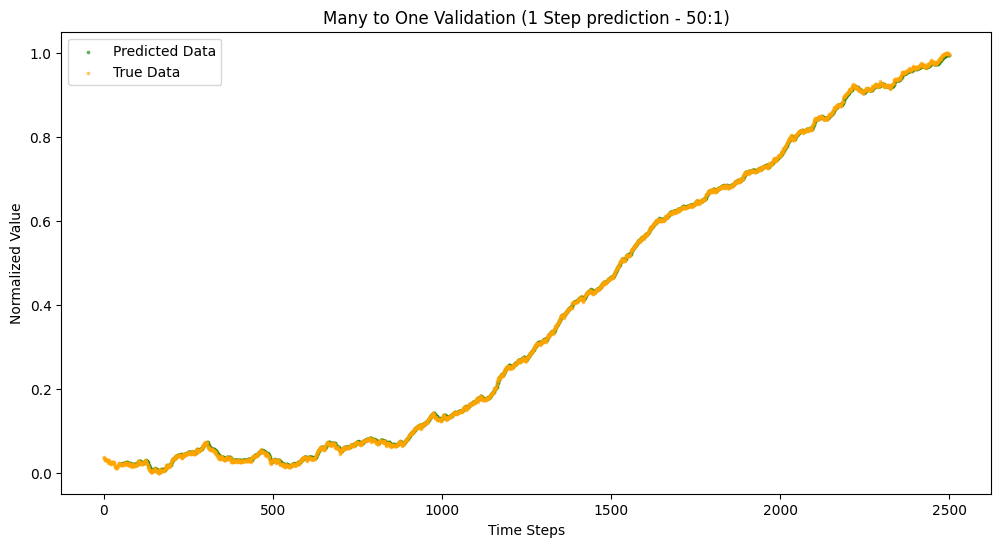

In [65]:
# Plot val_predictions vs val targets

plt.figure(figsize=(12, 6))
plt.scatter(range(50, len(val_dataset.data)), val_predictions, label="Predicted Data", color="green", s=3, alpha=0.5)
plt.scatter(range(len(val_dataset.data)), val_dataset.data, label="True Data", color="orange", s=3, alpha=0.5)
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title(f"Many to One Validation ({1} Step prediction - 50:1)")
plt.legend()
plt.show()



# Validate "soft" many to many

In [108]:
input_seq_len = 50
pred_hor = 300
inx = 2000

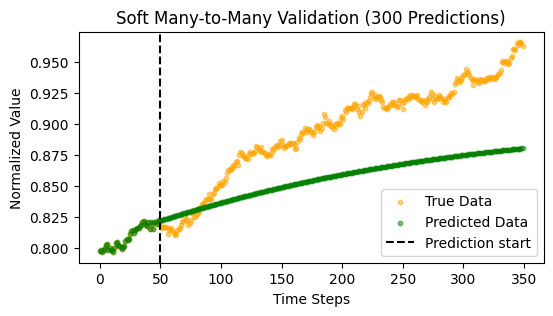

In [109]:

v = val_dataset.data[inx:inx+input_seq_len].squeeze().numpy()
true_targets = val_dataset.data[inx + input_seq_len:inx + input_seq_len + pred_hor].squeeze().numpy()
p = []

v_input = val_dataset.data[inx:inx+input_seq_len].reshape(1, -1, 1).to(device)
for _ in range(pred_hor):
    prediction = model(v_input)
    p.append(prediction.item())
    v_input = torch.cat((v_input[:, 1:], prediction.unsqueeze(0)), dim=1)



plt.figure(figsize=(6, 3))
plt.scatter(range(len(v) + len(true_targets)), np.concatenate((v, true_targets)), label="True Data", color="orange", marker="o", s=10, alpha=0.5)
plt.scatter(range(len(v) + len(true_targets)), np.concatenate((v, p)), label="Predicted Data", color="green", marker="o", s=10, alpha=0.5)
# vertical line 
plt.axvline(input_seq_len, color="black", linestyle="--", label="Prediction start")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title(f"Soft Many-to-Many Validation ({pred_hor} Predictions)")
plt.legend()
plt.show()

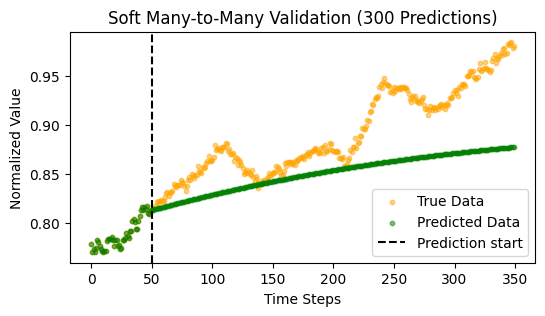

In [110]:
t = test_dataset.data[inx:inx+input_seq_len].squeeze().numpy()
true_targets = test_dataset.data[inx + input_seq_len:inx + input_seq_len + pred_hor].squeeze().numpy()
p_test = []

t_input = test_dataset.data[inx:inx+input_seq_len].reshape(1, -1, 1).to(device)
for _ in range(pred_hor):
    prediction = model(t_input)
    p_test.append(prediction.item())
    t_input = torch.cat((t_input[:, 1:], prediction.unsqueeze(0)), dim=1)

plt.figure(figsize=(6, 3))
plt.scatter(range(len(t) + len(true_targets)), np.concatenate((t, true_targets)), label="True Data", color="orange", marker="o", s=10, alpha=0.5)
plt.scatter(range(len(t) + len(true_targets)), np.concatenate((t, p_test)), label="Predicted Data", color="green", marker="o", s=10, alpha=0.5)
# vertical line 
plt.axvline(input_seq_len, color="black", linestyle="--", label="Prediction start")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title(f"Soft Many-to-Many Validation ({pred_hor} Predictions)")
plt.legend()
plt.show()


In [106]:
p_test

[0.5155896544456482,
 0.516515851020813,
 0.5174039006233215,
 0.51828932762146,
 0.5191737413406372,
 0.5200574994087219,
 0.5209406614303589,
 0.5218231678009033,
 0.5227047801017761,
 0.5235854983329773,
 0.5244650840759277,
 0.5253434777259827,
 0.5262206196784973,
 0.5270962715148926,
 0.527970552444458,
 0.5288434624671936,
 0.529714822769165,
 0.5305847525596619,
 0.5314531922340393,
 0.5323200821876526,
 0.5331854224205017,
 0.5340492725372314,
 0.5349116325378418,
 0.535772442817688,
 0.53663170337677,
 0.5374894738197327,
 0.5383456945419312,
 0.5392003655433655,
 0.5400535464286804,
 0.5409051775932312,
 0.5417552590370178,
 0.5426038503646851,
 0.5434508919715881,
 0.5442964434623718,
 0.5451404452323914,
 0.5459829568862915,
 0.5468239188194275,
 0.5476633906364441,
 0.5485013723373413,
 0.5493378043174744,
 0.5501726865768433,
 0.5510060787200928,
 0.5518379807472229,
 0.5526683926582336,
 0.5534972548484802,
 0.5543246269226074,
 0.5551505088806152,
 0.5559748411178589,


In [107]:
p

[0.5670235753059387,
 0.5678445100784302,
 0.5686477422714233,
 0.5694481134414673,
 0.5702464580535889,
 0.571043074131012,
 0.5718381404876709,
 0.5726317167282104,
 0.5734239220619202,
 0.5742146968841553,
 0.5750041604042053,
 0.575792133808136,
 0.576578676700592,
 0.5773637890815735,
 0.5781475305557251,
 0.5789298415184021,
 0.5797107815742493,
 0.580490231513977,
 0.581268310546875,
 0.5820449590682983,
 0.5828200578689575,
 0.5835939049720764,
 0.5843662619590759,
 0.5851371884346008,
 0.5859067440032959,
 0.5866749286651611,
 0.5874416828155518,
 0.5882070660591125,
 0.588970959186554,
 0.5897334814071655,
 0.5904945731163025,
 0.5912543535232544,
 0.5920128226280212,
 0.5927698016166687,
 0.5935254096984863,
 0.5942796468734741,
 0.5950325131416321,
 0.595784068107605,
 0.5965341925621033,
 0.5972829461097717,
 0.5980303287506104,
 0.5987764000892639,
 0.5995211005210876,
 0.6002644896507263,
 0.6010064482688904,
 0.6017470955848694,
 0.6024863719940186,
 0.6032242774963379,

In [97]:

seq_len = 50
num_predictions = 50
all_predictions = []
all_targets = []

for idx in range(len(val_dataset) - num_predictions):
    x, _ = val_dataset[idx]
    x = x.unsqueeze(0).to(device)

    predictions = []
    for _ in range(num_predictions):
        prediction = model(x)
        predictions.append(prediction.item())

        # auto regressive step (add prediction to the end of the sequence)
        x = torch.cat((x[:, 1:], prediction.unsqueeze(0)), dim=1)
    
    true_targets = val_dataset.data[idx + seq_len:idx + seq_len + num_predictions]

    all_predictions.extend(predictions)
    all_targets.append(true_targets.tolist())

all_targets_ = [t for sublist in all_targets for t in sublist]


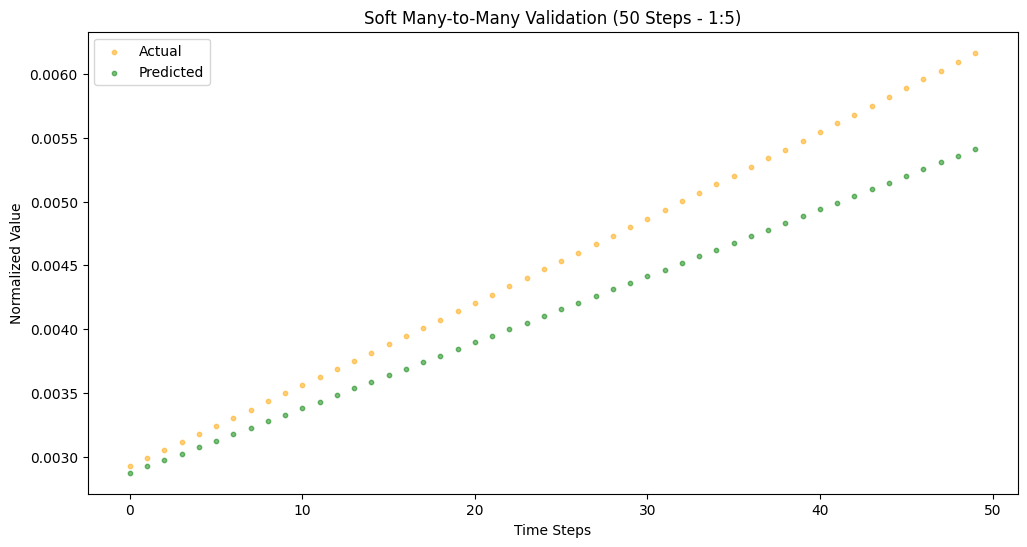

In [101]:
# Plot single sequence 
plt.figure(figsize=(12, 6))
plt.scatter(range(len(all_targets_[:50])), all_targets_[:50], label="Actual", color="orange", marker="o",s=10, alpha=0.5)
plt.scatter(range(len(all_predictions[:50])), all_predictions[:50], label="Predicted", color="green", marker="o", s=10, alpha=0.5)
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title(f"Soft Many-to-Many Validation ({num_predictions} Steps - 1:5)")
plt.legend()
plt.show()


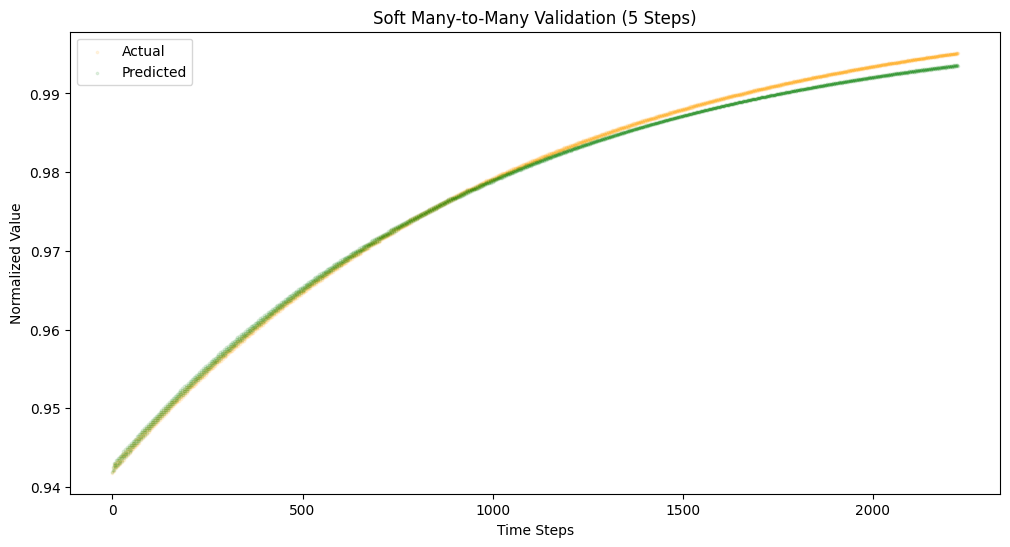

In [213]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(all_targets_)), all_targets_, label="Actual", color="orange", marker="o",s=3, alpha=0.1)
plt.scatter(range(len(all_predictions)), all_predictions, label="Predicted", color="green", marker="o", s=3, alpha=0.1)
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title(f"Soft Many-to-Many Validation ({num_predictions} Steps)")
plt.legend()
plt.show()

# Test loop


Test Loss: 0.000000


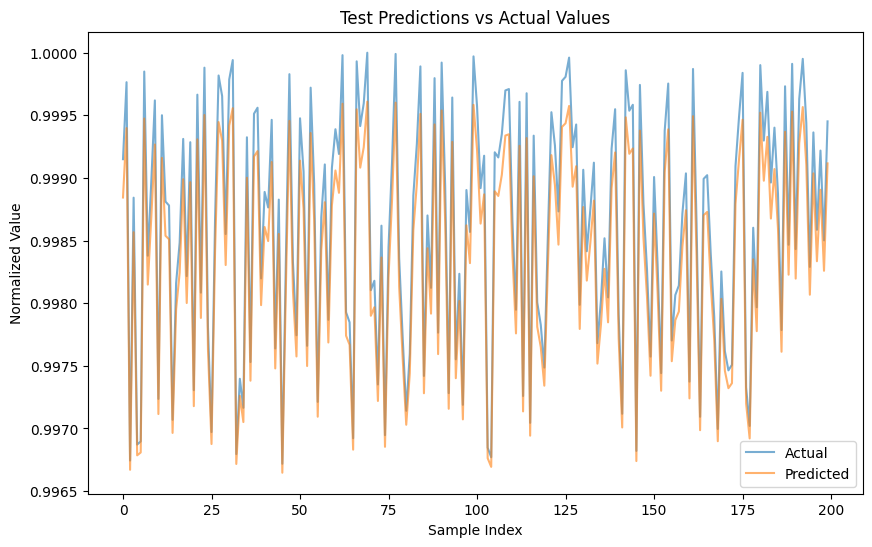

In [115]:
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for x_batch_test, y_batch_test in test_dataloader:
        x_batch_test, y_batch_test = x_batch_test.to(device), y_batch_test.to(device)
        predictions = model(x_batch_test)
        test_loss += criterion(predictions, y_batch_test).item()
        test_predictions.extend(predictions.cpu().numpy())
        test_targets.extend(y_batch_test.cpu().numpy())

test_loss /= len(test_dataloader)
print(f"Test Loss: {test_loss:.6f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(test_targets, label="Actual", alpha=0.6)
plt.plot(test_predictions, label="Predicted", alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Normalized Value")
plt.legend()
plt.title("Test Predictions vs Actual Values")
plt.show()
